# Setup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import plotly.express as px
import torch

import sys
sys.path.append("../../..")
from src.models import training_utils,base_model,sage_ones

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/"
experiments_folder = "../../../data/experiments/design_space_merged_experiment/seed_0/"

# Load a pretrained model

In [4]:
results = pd.read_parquet(experiments_folder+"experiment_16_06_23__17_59_43.parquet")

node_csv = pd.read_csv(data_folder+"merged_nodes.csv")
node_info = pd.read_csv(data_folder+"merged_node_info.csv")
edge_data = pd.read_csv(data_folder+"merged_edges.csv")

datasets, node_map = training_utils.load_data(data_folder+"split_dataset/seed_0/")
train_data, val_data = datasets

new_datasets, _ = training_utils.load_data(data_folder+"split_dataset/seed_4/")
new_train_data, new_val_data = new_datasets

In [5]:
df = pd.read_csv(data_folder+"split_dataset/seed_4/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

In [6]:
results.sort_values(by="auc",ascending=False)

,L2_norm,batch_norm,conv_type,delta,dropout,epochs,experiment_name,feature_dim,feature_type,heads,...,micro_aggregation,msg_passing_layers,normalize_output,patience,post_process_layers,pre_process_layers,supervision_types,weight_decay,auc,curve_data
62,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909951,"[[0.703677773475647, 0.6893664002418518, 0.676..."
55,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,3,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909892,"[[0.6917510628700256, 0.6621622443199158, 0.63..."
54,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909118,"[[0.6860914826393127, 0.6716712117195129, 0.65..."
59,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,3,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909058,"[[0.6657952666282654, 0.6534611582756042, 0.64..."
9,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.908880,"[[0.6850339770317078, 0.6739553809165955, 0.66..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,True,True,SAGEConv,0.1,0.1,400,GAT_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.821747,"[[0.691173255443573, 0.6777836084365845, 0.665..."
17,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.816867,"[[0.7043997645378113, 0.6885340809822083, 0.67..."
14,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.815617,"[[0.6883745789527893, 0.6758227944374084, 0.66..."
35,True,True,SAGEConv,0.1,0.1,400,GAT_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.797107,"[[0.6960344910621643, 0.6834494471549988, 0.67..."


In [7]:
def load_model(weights_path,supervision_types,metadata,model_args=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weights = torch.load(weights_path,map_location=torch.device(device))
    model = base_model.base_model(model_args,metadata,supervision_types)
    model.load_state_dict(weights)

    return model

In [8]:
model_params = ['hidden_channels', 'conv_type', 'batch_norm', 'dropout', 'micro_aggregation', 'macro_aggregation', 'layer_connectivity', 'L2_norm', 'pre_process_layers', 'msg_passing_layers', 'post_process_layers', 'normalize_output', 'jumping_knowledge']
eid = 62
params = results[model_params].loc[eid].to_dict()
weights_path = experiments_folder+"model_62_16_06_23__17_59_43.pth"

old_model = load_model(weights_path,[("gene_protein","gda","disease")],train_data.metadata(),params)

In [9]:
weights_path = "../../../data/experiments/merged_types_experiment/sage_ones_first_negatives_exp_04_07_23__12_07.pth"
weights = torch.load(weights_path)
new_model = sage_ones.Model(train_data.metadata(),[("gene_protein","gda","disease")])
new_model.load_state_dict(weights)

feature_type = "ones"
feature_dim = 10

train_data = training_utils.initialize_features(train_data, feature_type, feature_dim)
val_data = training_utils.initialize_features(val_data, feature_type, feature_dim)

new_train_data = training_utils.initialize_features(new_train_data, feature_type, feature_dim)
new_val_data = training_utils.initialize_features(new_val_data, feature_type, feature_dim)

# Get encodings

In [10]:
# feature_type = results.loc[eid,"feature_type"]
# feature_dim  = results.loc[eid,"feature_dim"]
# val_data = training_utils.initialize_features(val_data, feature_type, feature_dim)

In [11]:
old_encodings = training_utils.get_encodings(old_model,val_data)
new_encodings = training_utils.get_encodings(new_model,new_val_data)

# Prioritize

In [12]:
class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,apply_sigmoid=True):
        pred = (x_source * x_target).sum(dim=-1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

In [13]:
def prioritize(node_index,encodings_dict,node_df):
    assert df.index.name == "node_index", f"df index must be node_index, not {df.index.name}."

    decoder = inner_product_decoder()
    source_type = node_df.loc[node_index,"node_type"]
    tensor_index = node_df.loc[node_index,"tensor_index"]

    if source_type == "disease":
        target_type = "gene_protein"

    elif source_type == "gene_protein":
        target_type = "disease"

    source_vector = encodings_dict[source_type][tensor_index]
    target_matrix = encodings_dict[target_type]

    predicted_edges = decoder(target_matrix,source_vector)
    ranked_scores, ranked_indices = torch.sort(predicted_edges,descending=True)
    results = pd.DataFrame({"score":ranked_scores.cpu().numpy(),"tensor_index":ranked_indices.cpu().numpy()})
    results.score = results.score.round(3)

    index_map = df.loc[df.node_type == target_type,["tensor_index","node_name","degree_gda"]].reset_index()
    ranked_predictions = pd.merge(results,index_map,on="tensor_index")
    ranked_predictions.index.name = "rank"

    return ranked_predictions

In [36]:
df.sort_values(by="degree_gda",ascending=False)[200:]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
2816,1437,CSF2,gene_protein,disgenet,9910,NaN,NaN,103.0,9.0,0.0,112.0
10356,5173,PDYN,gene_protein,disgenet,13213,NaN,NaN,102.0,8.0,0.0,110.0
23153,C0270844,Tonic Seizures,disease,disgenet,1138,NaN,NaN,102.0,0.0,0.0,102.0
21138,C0043094,Weight Gain,disease,disgenet,1028,NaN,NaN,102.0,0.0,0.0,102.0
24070,C0346647,Malignant neoplasm of pancreas,disease,disgenet,264,24.0,3.0,102.0,0.0,6.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...
7973,3681,ITAD,gene_protein,hippie,14262,NaN,NaN,0.0,5.0,0.0,5.0
14488,729085,F198A,gene_protein,hippie,14257,NaN,NaN,0.0,1.0,0.0,1.0
13450,645922,S1A7B,gene_protein,hippie,14253,NaN,NaN,0.0,2.0,0.0,2.0


In [46]:
encodings = new_encodings
dataset = new_val_data

node_index = 2816
print(df.loc[node_index,"node_name"], df.loc[node_index,"degree_gda"])
predictions = prioritize(node_index,encodings,df)

CSF2 103.0


In [47]:
predictions

,score,tensor_index,node_index,node_name,degree_gda
rank,,,,,
0,0.875,776,18672,Atherosclerosis,59.0
1,0.874,965,18471,Adenocarcinoma,116.0
2,0.873,967,21915,"Carcinoma, Cribriform",116.0
3,0.873,956,21917,"Adenocarcinoma, Tubular",116.0
4,0.872,1563,19532,Congestive heart failure,110.0
...,...,...,...,...,...
16074,0.058,1690,32956,"SPASTIC PARAPLEGIA 62, AUTOSOMAL RECESSIVE",1.0
16075,0.058,3456,28753,ABLEPHARON-MACROSTOMIA SYNDROME,1.0
16076,0.058,11412,28399,Mitochondrial myopathy with lactic acidosis,1.0


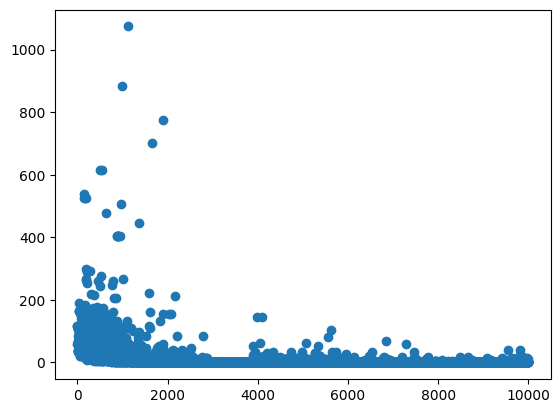

In [48]:
cut = 10000
plt.scatter(predictions[:cut].index.values, predictions[:cut].degree_gda.values)

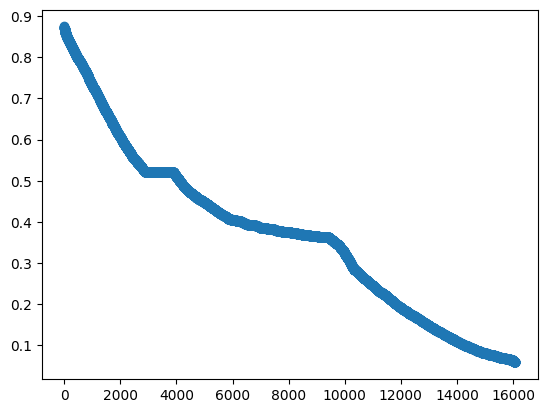

In [49]:
plt.scatter(predictions.index,predictions.score)

hacer esto mismo pero con los enlaces de validación y test por separado

In [30]:
def tensor_to_edgelist(tensor: torch.tensor):
    sources = tensor[0,:].tolist()
    targets = tensor[1,:].tolist()
    edgelist = list(zip(sources,targets))
    return edgelist

def reverse_map(node_map,edge_list,edge_type):
    """Maps edge dictionary from pyg Heterodata back into the original node indexes from the dataframe"""
    src_map = {v:k for k,v in node_map[edge_type[0]].items()}
    dst_map = {v:k for k,v in node_map[edge_type[2]].items()}
    mapped_edge_list = [(src_map[n1],dst_map[n2]) for (n1,n2) in edge_list]

    return mapped_edge_list

def inverse_map_heterodata(data,node_map):
    """Maps full edge data from pyg Heterodata back into the original node indexes from the dataframe"""
    edge_dict = {}
    for edge_type in data.edge_types:
        type_dict = {}
        edge_tensor = data[edge_type]["edge_index"]
        edge_list = tensor_to_edgelist(edge_tensor)
        mapped_edge_list = reverse_map(node_map,edge_list,edge_type)

        type_dict["message_passing_edges"] = mapped_edge_list

        if "edge_label_index" in data[edge_type].keys():
            labeled_edges_tensor = data[edge_type]["edge_label_index"]
            labeled_edges_list = tensor_to_edgelist(labeled_edges_tensor)
            mapped_labeled_edges_list = reverse_map(node_map,labeled_edges_list,edge_type)

            edge_labels = data[edge_type]["edge_label"].tolist()

            type_dict["supervision_edges"] = mapped_labeled_edges_list
            type_dict["supervision_labels"] = edge_labels
 
        edge_dict[edge_type] = type_dict
    
    return edge_dict

def edge_map_to_df(inverse_map_dict):
    edges_df = {}
    for edge_type,sub_dict in inverse_map_dict.items():
        if "supervision_edges" in sub_dict.keys():
            edges = pd.DataFrame(sub_dict["supervision_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})
            edge_labels_df = pd.concat([edges,pd.DataFrame(sub_dict["supervision_labels"])],axis=1).rename(columns={0:"label"})

            msg_passing_edges_df = pd.DataFrame(sub_dict["message_passing_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})

            edges_df[edge_type] = {"supervision_edges":edge_labels_df,"message_passing_edges":msg_passing_edges_df}
    
    return edges_df

In [31]:
old_validation_edges = inverse_map_heterodata(val_data,node_map)
old_train_edges = inverse_map_heterodata(train_data,node_map)

new_validation_edges = inverse_map_heterodata(new_val_data,node_map)
new_train_edges = inverse_map_heterodata(new_train_data,node_map)

In [50]:
mapped_dataset = inverse_map_heterodata(dataset,node_map)
df_dataset = edge_map_to_df(mapped_dataset)

node_type = df.loc[node_index,"node_type"]
y_type = "disease" if node_type == "gene_protein" else "gene_protein"

supervision_edges = df_dataset[("gene_protein","gda","disease")]["supervision_edges"]
node_supervision_edges = supervision_edges[supervision_edges[node_type] == node_index]

msg_edges = df_dataset[("gene_protein","gda","disease")]["message_passing_edges"]
node_msg_edges = msg_edges[msg_edges[node_type] == node_index]

node_type = df.loc[node_index,"node_type"]
y_type = "disease" if node_type == "gene_protein" else "gene_protein"

In [51]:
node_supervision_edges

,gene_protein,disease,label
545,2816,20963,1.0
888,2816,21218,1.0
1765,2816,21928,1.0
2028,2816,33921,1.0
2159,2816,21198,1.0
2516,2816,20148,1.0
2760,2816,20972,1.0
2861,2816,31819,1.0
6005,2816,21528,1.0
6022,2816,19872,1.0


In [52]:
k = 100
positive_sup = node_supervision_edges[node_supervision_edges.label == 1][y_type].values
predicted_top = predictions[:k]["node_index"].values

ranked_in_top = len(set(positive_sup).intersection(set(predicted_top)))
print(f"{ranked_in_top} de {len(positive_sup)} nodos positivos rankeados en top {k}")

4 de 14 nodos positivos rankeados en top 100


In [206]:
predictions.reset_index().set_index("node_index").loc[node_supervision_edges[y_type].values].sort_values(by="rank")

,rank,score,tensor_index,node_name,degree_gda
node_index,,,,,
11739,14,0.997,288,MAPK1,69.0
9493,24,0.997,13313,NGFR,35.0
9418,32,0.997,13,ATM,72.0
14265,44,0.997,915,TLR4,80.0
7905,71,0.997,1265,IL18,48.0
...,...,...,...,...,...
4107,13811,0.894,11518,FBXO45,1.0
16616,15119,0.862,14081,CGNL1,1.0
4992,15206,0.861,5428,PLCL2,1.0


In [160]:
predictions.reset_index().set_index("node_index").loc[node_msg_edges[y_type].values].sort_values(by="rank")

,rank,score,tensor_index,node_name,degree_gda
node_index,,,,,
11660,28,0.852,10930,KDM3A,1.0
5332,36,0.850,7439,SGK3,1.0
11228,38,0.850,4760,RPRD1A,1.0
6942,40,0.849,12240,GTF2A1,1.0
6973,71,0.845,12088,OLA1,1.0
...,...,...,...,...,...
2451,17516,0.485,9430,DNAJC21,8.0
8549,17561,0.476,11776,LIPE,6.0
251,17583,0.469,1183,ABCB6,16.0


enlaces en todo el grafo

In [161]:
existing_edges = edge_data.loc[(edge_data.x_index == node_index) & (edge_data.y_type == y_type),"y_index"].values
filtered_predictions = predictions.reset_index().set_index("node_index").loc[existing_edges].sort_values(by="rank")
filtered_predictions[:50]

,rank,score,tensor_index,node_name,degree_gda
node_index,,,,,
11660,28,0.852,10930,KDM3A,1.0
5332,36,0.850,7439,SGK3,1.0
11228,38,0.850,4760,RPRD1A,1.0
6942,40,0.849,12240,GTF2A1,1.0
6973,71,0.845,12088,OLA1,1.0
6464,72,0.845,5444,GOLGB1,1.0
18081,95,0.844,1719,PPM1F,2.0
15529,100,0.843,6368,WDCP,1.0
16404,102,0.843,8183,KBTBD8,1.0


In [162]:
k = 100
top_k_pred = predictions[:k].node_index.values
len(set(top_k_pred).intersection(set(existing_edges)))

7

# Veo qué enlaces quedaron en cada split

Verifico que son los mismos enlaces

In [49]:
validation_edges = old_validation_edges

edge_list = validation_edges[("gene_protein","gda","disease")]["message_passing_edges"]
gene_to_disease = [(b,a) for (a,b) in edge_list]
disease_to_gene = validation_edges[("disease","gda","gene_protein")]["message_passing_edges"]

len(set(gene_to_disease)&set(disease_to_gene)) == len(gene_to_disease)

True